In [ ]:
pip install pyqsp pennylane==0.41.1

In [ ]:
import numpy as np
from pyqsp.poly import PolyOneOverX

# Instantiate the PolyOneOverX class
poly_generator = PolyOneOverX()

# Define parameters
kappa = 3
epsilon = 0.001

# Generate Chebyshev coefficients for 1/x approximation
cheb_coeffs = poly_generator.generate(
    kappa=kappa,
    epsilon=epsilon,
    return_coef=True,
    ensure_bounded=True
)

from pyqsp.sym_qsp_opt import newton_solver
phases, err, total_iter, qsp_seq_opt = newton_solver(cheb_coeffs, parity=1, crit=1e-12)
print('phases', phases, ' with length', len(phases))


b=72, j0=30
[PolyOneOverX] minimum [-5.43885318] is at [-0.13228476]: normalizing
[PolyOneOverX] bounding to 0.9
[sym_qsp] Iterative optimization to err 1.000e-12 or max_iter 100.
iter: 001 --- err: 5.817e-01
iter: 002 --- err: 2.524e+00


KeyboardInterrupt: 

In [ ]:
## Here adding more information.For testing if it is correct

import pennylane as qml
from pennylane import numpy as np

dev = qml.device("default.qubit", wires=1)

def unitary_oracle(x):
    return np.array([[x, np.sqrt(1 - x**2)], [np.sqrt(1 - x**2), -x]])

@qml.qnode(dev)
def qsp_circuit(x):
    qml.StatePrep([1,0], wires=0)  # |0> state

    # Apply QSP sequence
    for phase in phases:
        qml.RZ(phase, wires=0)
        qml.QubitUnitary(unitary_oracle(x), wires=0)

    return qml.expval(qml.PauliZ(0))


In [ ]:
# Testing

x_vals = np.linspace(0.3, 1.0, 10)  # Example values for κ=3
for x in x_vals:
    qsp_result = qsp_circuit(x)
    classical_result = 1/x
    print(f"x={x:.2f}, QSP={qsp_result:.4f}, 1/x={classical_result:.4f}")


x=0.30, QSP=0.2073, 1/x=3.3333
x=0.38, QSP=-0.7270, 1/x=2.6471
x=0.46, QSP=-0.3706, 1/x=2.1951
x=0.53, QSP=0.1054, 1/x=1.8750
x=0.61, QSP=-0.4440, 1/x=1.6364
x=0.69, QSP=0.0952, 1/x=1.4516
x=0.77, QSP=-0.9489, 1/x=1.3043
x=0.84, QSP=0.0451, 1/x=1.1842
x=0.92, QSP=-0.4982, 1/x=1.0843
x=1.00, QSP=1.0000, 1/x=1.0000




```
# This is formatted as code
```

# Classiq Optimized their function

In [ ]:
pip install cvxpy matplotlib

In [ ]:
from pyqsp.angle_sequence import Polynomial, QuantumSignalProcessingPhases

Optimizing function for the f(x) = 1/x

In [ ]:
import numpy as np
import scipy

# the size of the unitary which block encodes A
REG_SIZE = 3


def get_random_unitary(num_qubits, seed=4):
    np.random.seed(seed)
    X = np.random.rand(2**num_qubits, 2**num_qubits)
    U, s, V = np.linalg.svd(X)
    return U @ V.T


U_a = get_random_unitary(REG_SIZE)

A_dim = int(U_a.shape[0] / 2)
A = U_a[:A_dim, :A_dim]
print(A)

[[-0.05338002 -0.36103662 -0.54016489 -0.39026125]
 [-0.33304121  0.10648228  0.37346704 -0.33977916]
 [ 0.4167817  -0.75180519  0.17593867  0.20944773]
 [ 0.26891079 -0.05333795 -0.32668787 -0.33602829]]


Max error value: 0.004700998285219249


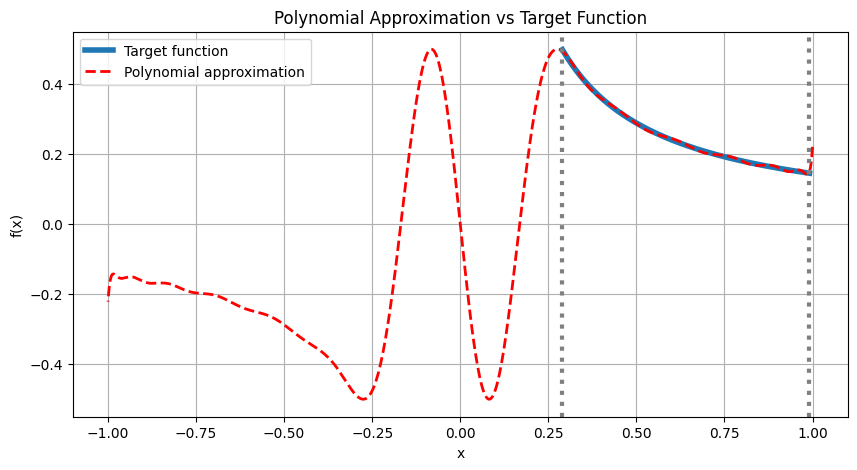

[ 0.          0.25054832  0.         -0.14629239  0.          0.08051086
  0.          0.00135102  0.         -0.03904751  0.          0.08628945
  0.         -0.09197067  0.          0.10660837  0.         -0.08916949
  0.          0.08359965  0.         -0.057867    0.          0.04664974
  0.         -0.02450966  0.          0.01879831  0.         -0.00429364]


In [ ]:
import cvxpy as cp
import matplotlib.pyplot as plt


def optimize_inversion_polynomial(w_min, w_max, degree, M=1000, plot=True):
    # Discretize [-1, 1] using M grid points (interpolants)
    xj_full = np.cos(np.pi * np.arange(M) / (M - 1))  # Chebyshev nodes on [-1, 1]

    # Select grid points for the objective in [w_min, w_max]
    xj_obj = xj_full[(xj_full >= w_min) & (xj_full <= w_max)]

    # Define the Chebyshev polynomials of odd degrees
    k_max = (degree - 1) // 2
    T_matrix_full = np.array(
        [
            [np.cos((2 * k + 1) * np.arccos(x)) for k in range(k_max + 1)]
            for x in xj_full
        ]
    )
    T_matrix_obj = np.array(
        [[np.cos((2 * k + 1) * np.arccos(x)) for k in range(k_max + 1)] for x in xj_obj]
    )

    # Define optimization variables
    c = cp.Variable(k_max + 1)  # Coefficients for Chebyshev polynomials
    F_values_full = T_matrix_full @ c  # Values for constraints
    F_values_obj = T_matrix_obj @ c  # Values for the objective function

    # Relaxed constraint
    scale = 0.5

    def target_function(x):
        return scale * (w_min) / x

    # Define the optimization problem
    objective = cp.Minimize(cp.max(cp.abs(F_values_obj - target_function(xj_obj))))
    constraints = [cp.abs(F_values_full) <= scale]
    prob = cp.Problem(objective, constraints)

    # Solve the optimization problem
    prob.solve()
    print(f"Max error value: {prob.value}")

    # Return coefficients, optimal value, and grid points
    pcoefs = np.zeros(len(c.value) * 2)
    pcoefs[1::2] = c.value

    if plot:
        y_target = target_function(xj_obj)
        y_approx = np.polynomial.Chebyshev(pcoefs)(xj_full)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(xj_obj, y_target, label="Target function", linewidth=4)
        plt.plot(
            xj_full,
            y_approx,
            "--",
            label="Polynomial approximation",
            linewidth=2,
            c="r",
        )
        plt.title("Polynomial Approximation vs Target Function")
        plt.xlabel("x")
        plt.ylabel("f(x)")
        # Draw vertical lines
        plt.axvline(w_min, color="gray", linestyle=":", linewidth=3)
        plt.axvline(w_max, color="gray", linestyle=":", linewidth=3)

        plt.legend()
        plt.grid(True)
        plt.show()

    return pcoefs, scale


svd = np.linalg.svd(A)[1]
# print(svd)
pcoefs, scale = optimize_inversion_polynomial(min(svd), max(svd), degree=30)
print(pcoefs)

In [ ]:
print(pcoefs)

[ 0.          0.25054832  0.         -0.14629239  0.          0.08051086
  0.          0.00135102  0.         -0.03904751  0.          0.08628945
  0.         -0.09197067  0.          0.10660837  0.         -0.08916949
  0.          0.08359965  0.         -0.057867    0.          0.04664974
  0.         -0.02450966  0.          0.01879831  0.         -0.00429364]


In [ ]:
# change the R(x) to W(x), as the phases are in the W(x) conventions
phases = np.array(pcoefs)
phases[1:-1] = phases[1:-1] - np.pi / 2
phases[0] = phases[0] - np.pi / 4
phases[-1] = phases[-1] + (2 * (len(phases) - 1) - 1) * np.pi / 4

# verify conventions. minus is due to exp(-i*phi*z) in qsvt in comparison to qsp
phases = -2 * phases
print(phases)

[  1.57079633   2.64049602   3.14159265   3.43417744   3.14159265
   2.98057093   3.14159265   3.13889062   3.14159265   3.21968768
   3.14159265   2.96901375   3.14159265   3.32553399   3.14159265
   2.92837591   3.14159265   3.31993163   3.14159265   2.97439336
   3.14159265   3.25732665   3.14159265   3.04829317   3.14159265
   3.19061198   3.14159265   3.10399603   3.14159265 -89.52680334]
